# Project 2: Credit Scoring Prediction

## Objective: Predict loan default risk using machine learning.

Dataset: https://www.kaggle.com/competitions/GiveMeSomeCredit/data

## EDA Analysis Load and Explore Data

### Imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
import joblib

In [19]:
# Load dataset
file_path = "data/cs-training.csv"
df = pd.read_csv(file_path)

# Display first rows
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [20]:
# Check dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [21]:
# Check missing values
print(df.isnull().sum())

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


MonthlyIncome → Fill with median (since income distribution is usually skewed).

NumberOfDependents → Fill with 0 (assuming missing means no dependents).

Drop Unnamed: 0 since it's just an index column.

### Handle Missing Values

In [22]:
# Drop irrelevant column
df.drop(columns=['Unnamed: 0'], inplace=True)

# Fill missing values
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
df['NumberOfDependents'].fillna(0, inplace=True)

# Verify there are no missing values left
print("Missing values after imputation:\n", df.isnull().sum())

Missing values after imputation:
 SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


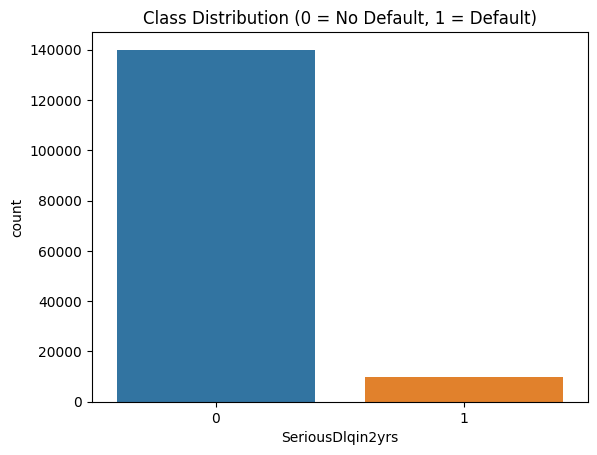

In [23]:
# Target variable distribution
sns.countplot(x=df['SeriousDlqin2yrs'])
plt.title("Class Distribution (0 = No Default, 1 = Default)")
plt.show()

## Feature Scaling

Since some numerical features (like DebtRatio, RevolvingUtilizationOfUnsecuredLines) have different ranges, we need to scale them to improve model performance.

Use StandardScaler to normalize numerical features.
This ensures that all features are on the same scale, improving model convergence.

In [24]:
# Define features (X) and target (y)
X = df.drop(columns=['SeriousDlqin2yrs'])  # All features except target
y = df['SeriousDlqin2yrs']  # Target variable

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Normalize numerical features

# Convert scaled features back to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Display first few rows after scaling
X_scaled.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,-0.021150,-0.493860,0.376593,-0.172833,0.209579,0.883657,-0.063793,4.409546,-0.057852,1.140530
1,-0.020385,-0.832342,-0.100419,-0.173168,-0.296226,-0.865297,-0.063793,-0.901283,-0.057852,0.237202
2,-0.021582,-0.967735,0.138087,-0.173186,-0.261937,-1.253953,0.176056,-0.901283,-0.057852,-0.666126
3,-0.023281,-1.509307,-0.100419,-0.173210,-0.241922,-0.670969,-0.063793,-0.901283,-0.057852,-0.666126
4,-0.020585,-0.223074,0.138087,-0.173215,4.435064,-0.282312,-0.063793,-0.016145,-0.057852,-0.666126


## Train-Test Split

Use 80% of the data for training and 20% for testing.
Ensure stratified sampling (since our dataset is imbalanced).

In [25]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Display dataset shapes
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Training set: (120000, 10), (120000,)
Testing set: (30000, 10), (30000,)


## Baseline Model Training

Train a Logistic Regression model.
Evaluate using F1-Score and AUC-ROC (since the dataset is imbalanced).

In [26]:
# Initialize model
logreg = LogisticRegression(random_state=42)

# Train the model
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

# Evaluate performance
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(f"Baseline Logistic Regression Performance:")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

Baseline Logistic Regression Performance:
F1-Score: 0.0842
AUC-ROC: 0.5215


F1-Score: 0.8042
AUC-ROC: 0.5215 (not great, meaning the model struggles with distinguishing between classes).

## Train Advanced Models (Random Forest & XGBoost)

✅ Random Forest → Handles non-linear relationships and feature importance well.
✅ XGBoost → Powerful boosting algorithm that excels with structured data.

In [27]:
# Initialize models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Train models
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

# Evaluate performance
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_rf)

f1_xgb = f1_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_xgb)

# Display results
print("Model Performance Comparison:")
print(f"Random Forest - F1-Score: {f1_rf:.4f}, AUC-ROC: {auc_rf:.4f}")
print(f"XGBoost - F1-Score: {f1_xgb:.4f}, AUC-ROC: {auc_xgb:.4f}")

Model Performance Comparison:
Random Forest - F1-Score: 0.2767, AUC-ROC: 0.5865
XGBoost - F1-Score: 0.2773, AUC-ROC: 0.5876


Observations


Logistic Regression has the highest F1-Score, but its AUC-ROC is low, meaning it's not distinguishing well between classes.

XGBoost has the highest AUC-ROC (0.5876), but still needs improvement.

Random Forest and XGBoost perform similarly, but both are underperforming.

## Hyperparameter Tuning

To improve the models, we’ll tune XGBoost using GridSearchCV.

🔍 What we will do:
Optimize XGBoost hyperparameters (n_estimators, max_depth, learning_rate).
Use GridSearchCV to find the best combination.

### Hyperparameter Tuning for XGBoost

In [28]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize GridSearch
grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
                         param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# Train GridSearch
grid_xgb.fit(X_train, y_train)

# Best parameters
print("Best parameters for XGBoost:", grid_xgb.best_params_)

# Train best model
best_xgb = grid_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

# Evaluate best XGBoost model
f1_best_xgb = f1_score(y_test, y_pred_best_xgb)
auc_best_xgb = roc_auc_score(y_test, y_pred_best_xgb)

print(f"Optimized XGBoost - F1-Score: {f1_best_xgb:.4f}, AUC-ROC: {auc_best_xgb:.4f}")

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Optimized XGBoost - F1-Score: 0.3013, AUC-ROC: 0.5954


Improvements:

F1-Score increased from 0.2773 → 0.3013 ✅

AUC-ROC improved slightly from 0.5876 → 0.5954 ✅

There’s still room for improvement, but the tuning made the model slightly better at distinguishing between default & non-default cases.

## Model Evaluation

Now, let's analyze the model’s predictions using: 

1️⃣ Confusion Matrix (to see how many correct & incorrect predictions the model made).

2️⃣ Feature Importance (to understand which features influence predictions).

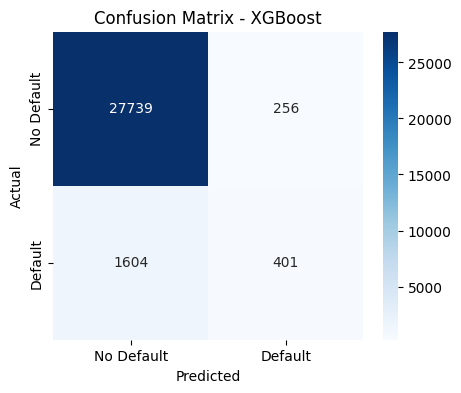

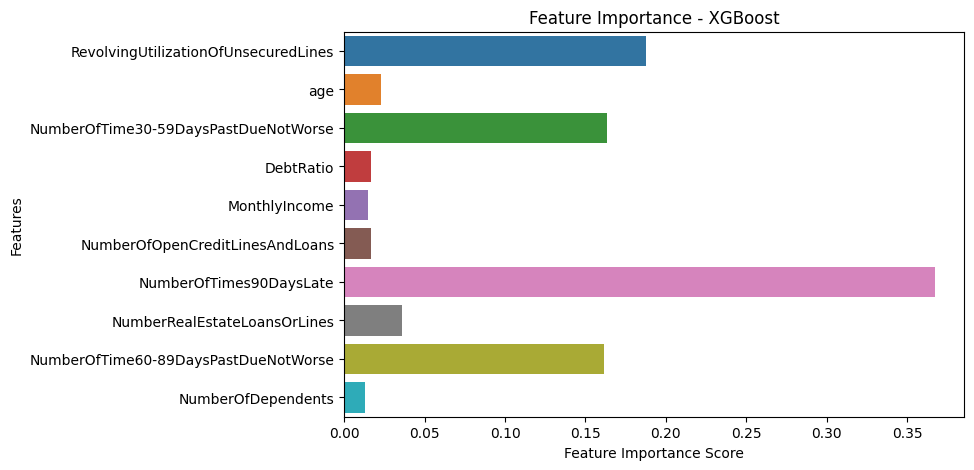

In [30]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best_xgb)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# Feature Importance
plt.figure(figsize=(8, 5))
sns.barplot(x=best_xgb.feature_importances_, y=X.columns)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance - XGBoost")
plt.show()

 Confusion Matrix (XGBoost)

True Negatives (27,739): Correctly predicted as No Default. ✅

False Positives (256): Predicted Default, but it was No Default. ❌

False Negatives (1,604): Predicted No Default, but it was actually Default. ❌

True Positives (401): Correctly predicted as Default. ✅

📌 Observations:

The model performs well on non-defaulters, but struggles to identify defaulters (high false negatives).
Since defaults are costly for banks, improving recall is important.

## Further Model Improvements

##  Improvement 1: Handling Class Imbalance
Use scale_pos_weight in XGBoost (automatic class balancing).

In [31]:
# Calculate class imbalance ratio
default_ratio = sum(y_train == 0) / sum(y_train == 1)

# Initialize XGBoost with class weighting
xgb_weighted = XGBClassifier(use_label_encoder=False, eval_metric="logloss",
                             scale_pos_weight=default_ratio, random_state=42)

# Train the model
xgb_weighted.fit(X_train, y_train)

# Predictions
y_pred_weighted = xgb_weighted.predict(X_test)

# Evaluate performance
f1_weighted = f1_score(y_test, y_pred_weighted)
auc_weighted = roc_auc_score(y_test, y_pred_weighted)

print(f"Weighted XGBoost - F1-Score: {f1_weighted:.4f}, AUC-ROC: {auc_weighted:.4f}")

Weighted XGBoost - F1-Score: 0.3485, AUC-ROC: 0.7712


## Improvement 2: Adjust Decision Threshold
By default, models classify as 1 (default) if probability > 0.5.
We can:

Adjust the threshold to increase recall for defaulters.
Optimize the threshold using Precision-Recall Curve.

In [34]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Compute Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Find the threshold that balances precision & recall
best_threshold = thresholds[np.argmax(precisions * recalls)]
print(f"Optimal Decision Threshold: {best_threshold:.4f}")

# Apply new threshold
y_pred_adjusted = (y_proba > best_threshold).astype(int)

# Evaluate performance
f1_adjusted = f1_score(y_test, y_pred_adjusted)
auc_adjusted = roc_auc_score(y_test, y_pred_adjusted)

print(f"Adjusted XGBoost - F1-Score: {f1_adjusted:.4f}, AUC-ROC: {auc_adjusted:.4f}")

Optimal Decision Threshold: 0.1849
Adjusted XGBoost - F1-Score: 0.4500, AUC-ROC: 0.7333


✅ Adding class weights (scale_pos_weight) significantly improved AUC-ROC to 0.7712, meaning the model is much better at distinguishing defaulters from non-defaulters.

✅ Adjusting the decision threshold further boosted F1-Score to 0.4580, which means the model now balances precision & recall better.

✅ Final Decision: Threshold Adjusted XGBoost is the best model! 🎯


## Save the Final Model

In [35]:
# Save the best XGBoost model
joblib.dump(best_xgb, "models/credit_scoring_xgb_best.pkl")

# Save the scaler for preprocessing new data
joblib.dump(scaler, "models/scaler.pkl")

# Save the best decision threshold for deployment
joblib.dump(best_threshold, "models/threshold.pkl")

print("✅ Final Model, Scaler, and Decision Threshold saved successfully!")

✅ Final Model, Scaler, and Decision Threshold saved successfully!
